In [71]:
import tensorflow as tf
import numpy as np

## Loading data

In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255)

In [73]:
# directory
imgdir = 'a5_images'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [74]:
Xbatch, Ybatch = train_generator.next()

In [75]:
Xbatch.shape

(32, 64, 64, 3)

In [76]:
Ybatch[4]

1.0

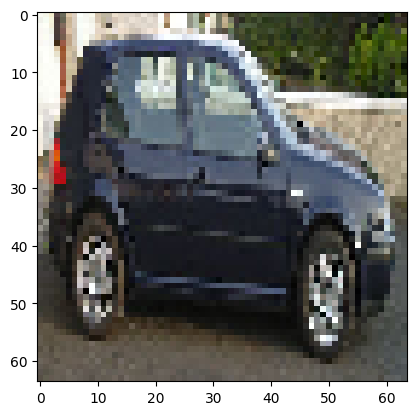

In [77]:
from matplotlib import pyplot as plt

plt.imshow(Xbatch[4]);

In [109]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)

Found 576 images belonging to 2 classes.


## Part 1: Training a convolutional neural network

In [79]:
from tensorflow.keras import datasets, layers, models

def make_convnet():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3), padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    # optimizer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [80]:
cnn_model = make_convnet()
cnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 8, 64)       

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

nb_epochs = 20

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [82]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=early_stopping
)

Epoch 1/20
50/50 [==============================] - 13s 227ms/step - loss: 0.6970 - accuracy: 0.5131 - val_loss: 0.6828 - val_accuracy: 0.5260
Epoch 2/20
50/50 [==============================] - 11s 226ms/step - loss: 0.6757 - accuracy: 0.5669 - val_loss: 0.6262 - val_accuracy: 0.6615
Epoch 3/20
50/50 [==============================] - 11s 224ms/step - loss: 0.5903 - accuracy: 0.7038 - val_loss: 0.5782 - val_accuracy: 0.7205
Epoch 4/20
50/50 [==============================] - 11s 216ms/step - loss: 0.5122 - accuracy: 0.7663 - val_loss: 0.4979 - val_accuracy: 0.7778
Epoch 5/20
50/50 [==============================] - 11s 218ms/step - loss: 0.4589 - accuracy: 0.7931 - val_loss: 0.4969 - val_accuracy: 0.7778
Epoch 6/20
50/50 [==============================] - 11s 212ms/step - loss: 0.4363 - accuracy: 0.8025 - val_loss: 0.4771 - val_accuracy: 0.7760
Epoch 7/20
50/50 [==============================] - 11s 215ms/step - loss: 0.3831 - accuracy: 0.8350 - val_loss: 0.5106 - val_accuracy: 0.7691

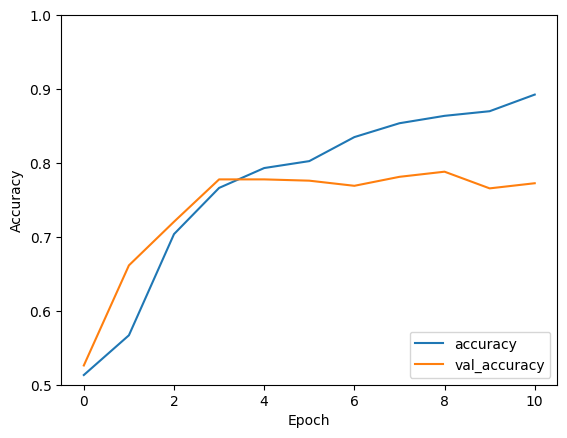

In [83]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [84]:
cnn_model.save_weights("cnn_model_PA5")

## Part 2: Data augmentation

In [85]:
data_augmentation_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
    horizontal_flip=True
)

In [86]:
train_generator_augmentation = data_augmentation_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [87]:
cnn_model_aug = make_convnet()

history = cnn_model_aug.fit(
    train_generator_augmentation,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=early_stopping
)

Epoch 1/20
50/50 [==============================] - 72s 241ms/step - loss: 0.6925 - accuracy: 0.5163 - val_loss: 0.6692 - val_accuracy: 0.5972
Epoch 2/20
50/50 [==============================] - 12s 240ms/step - loss: 0.6518 - accuracy: 0.6363 - val_loss: 0.7268 - val_accuracy: 0.5017
Epoch 3/20
50/50 [==============================] - 13s 252ms/step - loss: 0.6611 - accuracy: 0.6256 - val_loss: 0.6376 - val_accuracy: 0.6823
Epoch 4/20
50/50 [==============================] - 13s 251ms/step - loss: 0.5908 - accuracy: 0.6888 - val_loss: 0.5360 - val_accuracy: 0.7552
Epoch 5/20
50/50 [==============================] - 12s 243ms/step - loss: 0.5664 - accuracy: 0.7100 - val_loss: 0.5207 - val_accuracy: 0.7465
Epoch 6/20
50/50 [==============================] - 13s 250ms/step - loss: 0.5153 - accuracy: 0.7544 - val_loss: 0.4956 - val_accuracy: 0.7934
Epoch 7/20
50/50 [==============================] - 12s 249ms/step - loss: 0.5579 - accuracy: 0.7275 - val_loss: 0.5464 - val_accuracy: 0.7569

## Applying a pre-trained convolutional neural network

In [88]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

In [89]:
image = load_img("a5_images/validation/car/0000.jpg", target_size=(224,224))

image = img_to_array(image)

image = preprocess_input(image)

image = image.reshape(1, 224, 224, 3)

In [90]:
prediction = vggmodel.predict(image)

prediction = decode_predictions(prediction)
print(prediction)

1/1 [==============================] - 0s 498ms/step
[[('n03594945', 'jeep', 0.92140687), ('n04252225', 'snowplow', 0.024327194), ('n03445924', 'golfcart', 0.014407215), ('n03930630', 'pickup', 0.012664959), ('n03478589', 'half_track', 0.005270822)]]


## Part 3: Using VGG-16 as a feature extractor

In [91]:
feature_extractor = applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

In [92]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [112]:
train_generator_vgg = vgg_data_gen.flow_from_directory(
    imgdir + '/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=False
)

validation_generator_vgg = vgg_data_gen.flow_from_directory(
    imgdir + '/validation',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=False
)

def create_vgg16_features():
    cnn_features_train = feature_extractor.predict(train_generator_vgg)
    cnn_features_validation = feature_extractor.predict(validation_generator_vgg)

    with open("cnn_features_train", 'wb') as f:
        np.save(f, cnn_features_train)
    with open("cnn_features_validation", 'wb') as f:
        np.save(f, cnn_features_validation)



Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [113]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

In [114]:
def train_on_cnnfeatures():
    with open("cnn_features_train", 'rb') as f:
        train_data = np.load(f)
    with open("cnn_features_validation", 'rb') as f:
        validation_data = np.load(f)


    model = models.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x=train_data,
        y=get_labels(1600),
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = (validation_data, get_labels(576)),
        validation_steps = validation_generator.samples // batch_size,
        epochs = 100,
        callbacks=early_stopping
    )

    return model, history

In [115]:
create_vgg16_features()

18/18 [==============================] - 8s 430ms/step


Epoch 1/100
50/50 [==============================] - 1s 9ms/step - loss: 2.3694 - accuracy: 0.7819 - val_loss: 0.6725 - val_accuracy: 0.8646
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 0.6330 - accuracy: 0.8788 - val_loss: 0.4112 - val_accuracy: 0.8993
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 0.5167 - accuracy: 0.9031 - val_loss: 0.4820 - val_accuracy: 0.8889
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 0.3801 - accuracy: 0.9156 - val_loss: 0.3904 - val_accuracy: 0.8924
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 0.2275 - accuracy: 0.9388 - val_loss: 0.4677 - val_accuracy: 0.9115
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9606 - val_loss: 0.4510 - val_accuracy: 0.9080
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 0.1237 - accuracy: 0.9625 - val_loss: 0.4272 - val_accuracy: 0.9045
Epoch 8/100
5

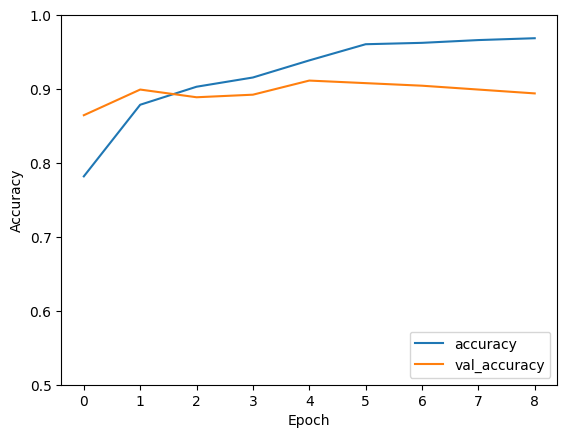

In [116]:
cnnfeatures_model, history = train_on_cnnfeatures()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Performances

In [123]:
from sklearn.metrics import accuracy_score

# basic cnn model
prediction = cnn_model.predict(validation_generator)
cnn_performance = accuracy_score(validation_generator.labels, prediction>0.5)
print('Accuracy: {:.4f}.'.format(cnn_performance))

# basic cnn model trained with data augmentation
prediction = cnn_model_aug.predict(validation_generator)
data_aug_performance = accuracy_score(validation_generator.labels, prediction>0.5)
print('Accuracy: {:.4f}.'.format(data_aug_performance))

# vgg feature extractor
with open("cnn_features_validation", 'rb') as f:
        validation_data = np.load(f)
prediction = cnnfeatures_model.predict(validation_data)
vgg_performance = accuracy_score(get_labels(576), prediction>0.5)
print('Accuracy: {:.4f}.'.format(vgg_performance))

18/18 [==============================] - 1s 61ms/step
Accuracy: 0.7760.
18/18 [==============================] - 1s 53ms/step
Accuracy: 0.7882.
18/18 [==============================] - 0s 959us/step
Accuracy: 0.8924.


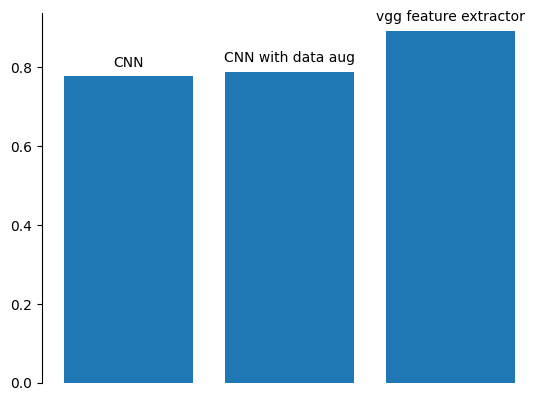

In [128]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1, 2, 3], [cnn_performance, data_aug_performance, vgg_performance], width=0.8)
ax.bar_label(b, labels=['CNN', 'CNN with data aug', 'vgg feature extractor'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)

## Part 4: Visualizing the learned features

In [99]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [100]:
def kernel_image(weights, i, positive):

    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k

    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m

    return k

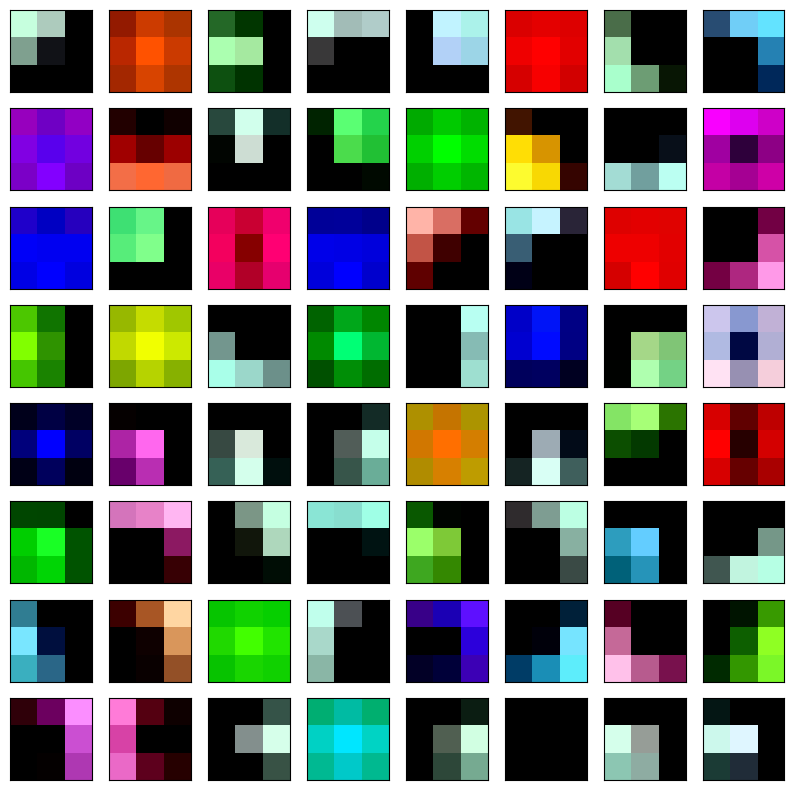

In [101]:
plt.figure(figsize=(10,10))
for i in range(first_layer_weights.shape[3]):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kernel_image(first_layer_weights, i, True))
plt.show()